# Keras Implementation of GAN Model to Generate CIFAR10 images (3-channels [RGB] images)

Link to the Youtube tutorial video: https://www.youtube.com/watch?v=TXy5wZknie8&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=4

1) In this tutorial, there are 3 parts:
    1) Define all the supplimentary functions that involved in the GAN model training.
    2) Perform GAN model training using CIFAR10 dataset as real images
    3) Deploy the trained generator network to generate images, by using the randomly generated latent vectors as input

In [28]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

# Load the dataset

Usually, the smaller the dimension of an image, the easier we can identify the class of the object appears in that image.

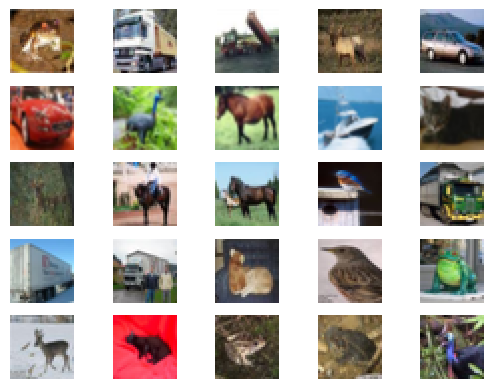

In [29]:
# Load the CIFAR10 dataset, then plot the first 25 samples of the dataset to get a quick understanding
# CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

(trainX, trainy), (testX, testy) = load_data()

# Plot the first 25 samples of the dataset as a subplot
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

# Define the function to build and compile the discriminator network

1) Using Sequential method from Keras as it makes the definition of models easy. 
2) We will use functional way of defining the model for the conditional GAN but sequential way for descriminator and generator as they are straightforward.
3) When we perform convolution operation on an image, we are reducing the image dimension (dowmsampling).
4) Given an input image, the Discriminator(discriminator network) outputs the likelihood(probability) of the image being real.

In [30]:
# Define the standalone discriminator model
# Given an input image, the Discriminator(discriminator network) outputs the likelihood(probability) of the image being real.
# Hence, the discriminator network is a binary classifier that performs binary classification - true or false (1[real image] or 0[fake image]). So using sigmoid activation at the output layer.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
    # "128, (3,3), strides=(2,2)" means the convolution layer has 128 filters, each filter has dimension of 2x2 pixels that move 2 pixel steps at each convolution operation. 
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) # Each output image from this convolution layer has shape of 16x16x128, means each output image from this convolution layer has a dimension of 16x16 pixels, with 128 channels. Means each input image of this convolution layer has shape of (32,32,3), each output image of this convolution layer has shape of (16,16,128).
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # Each output image from this convolution layer has shape of 8x8x128, means each output image from this convolution layer has a dimension of 8x8 pixels, with 128 channels. Means each input image of this convolution layer has shape of (16,16,128), each output image of this convolution layer has shape of (8, 8,128).
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten()) # Means each input image of this flatten layer has shape of (8,8,128), each output image of this flatten layer has shape of (8192,1) [1D, a string of numbers]. 
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) # Means each input image of this Dense layer has shape of (8192,1) [1D, a string of numbers], each output image of this Dense layer has shape of (1,1) [1D, a value].
	
    # Compile model
	opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

# Define the function to build the generator network

1) Here we are only using Dense layer to find the relationship (weights and biases) between each image feature and Conv2DTranspose layer to perform deconvolution/upsampling operation to build the generator network structure. But the generator network structure can be complicated based on your application. For example, you can use VGG for super resolution GAN.       
2) The generator network is not compiled as it is not directly trained like the discriminator. Generator is trained via GAN combined model. 
3) Given an input noise/latent vector, the Generator(generator network) outputs an image (fake image) that has dimension of 32x32 pixels, with 3 channels.

In [31]:
# Define the standalone generator model.
# Given input of noise/latent vector, the Generator (generator network) produces an image.(Here, the generator network produces an image having dimension 32x32 pixels as the output for each latent vector as the input).
# latent_dim (the size of a latent vector), for example, can be 100, 1D array of size 100 (means a 1D vector that having 100 elements/values) .

# Here we are only using Dense layer to find the relationship (weights and biases) between each image feature and Conv2DTranspose layer to perform deconvolution/upsampling operation to build the generator network structure. But the generator network structure can be complicated based on your application. For example, you can use VGG for super resolution GAN.       

def define_generator(latent_dim):    # latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape each input latent vector into an image having dimension of 8x8 pixels as the output using a Dense layer as a starting point. 
    # So n_nodes (number of neurons/nodes/units in a layer) for that Dense layer can be 128x8x8=8192 so when we reshape each output image of the Dense layer, 
    # it would be 8x8x128 (each output image of the Dense layer is reshaped into an image having dimension of 8x8 pixels, with 128 channels) and that can be slowly upscaled to 32x32 image for output (to match the image shape of the input of the discriminator network).
	n_nodes = 128 * 8 * 8  # 128*8*8=8192 nodes/neurons/units
	model.add(Dense(n_nodes, input_dim=latent_dim)) # This is a Dense layer, so we can work with 1D latent vector. Means each input of the generator network requires the shape of (100,1) [means 1D vector of 100 elements/values].
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  # 8x8x128 dataset from the latent vector. Means reshape each input of (100,1) latent vector into an (8,8,128) image as the output.
	# upsample each image to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # Means each input image of this deconvolution layer has shape of (8,8,128), each output image of this deconvolution layer has shape of (16,16,128).
	model.add(LeakyReLU(alpha=0.2))
	# upsample each image to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # Means each input image of this deconvolution layer has shape of (16,16,128), each output image of this deconvolution layer has shape of (32,32,128).
	model.add(LeakyReLU(alpha=0.2))
	# generate the final version of fake image for each latent vector as input
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) # Means each input image of this deconvolution layer has shape of (32,32,128), each output image of this deconvolution layer has shape of (32,32,3). Now, the generated image from this generator network output layer has dimension of 32x32 pixels, with 3 channels.
	return model  # Model not compiled as it is not directly trained like the discriminator. Generator is trained via GAN combined model. 

test_gen = define_generator(100) # We provide 100 as input to the function just to print the summary of the model (because without input, the summary() won't work)
print(test_gen.summary()) # Show the summary of the generator network

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 32, 32, 128)     

# Define the function to build and compile the GAN model

We call this GAN model whenever we want to train the generator network.

In [32]:
# Define the GAN model (combined generator and discriminator model), for updating the weights and biases of generator network during training at each epoch.
# Discriminator network is trained separately, so here only generator will be trained by keeping the discriminator constant. 
def define_gan(generator, discriminator):
	discriminator.trainable = False  # Discriminator network is trained separately, so set the discriminator network to not trainable.
	# Connect generator network to discriminator network, as a GAN model
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# Compile the GAN model
	opt = adam_v2.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Define the function to load images (real images) from the CIFAR10 dataset, then rescale the real images

Since the generator network output layer uses tanh activation function (tanh activation function provides an output value in the range from -1 to 1), we convert(rescale) each feature (pixel value) of each real image (from dataset) into the range from -1 to 1 to match the output of generator.

In [33]:
# Load CIFAR training images
def load_real_samples():
	(trainX, _), (_, _) = load_data() # we only load the features of the train set image of the dataset
	# Convert each feature (pixel value) of each real image (from dataset) into a float number
	X = trainX.astype('float32')
	# Scale each feature (pixel value) of each real image (from dataset) from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  # Since the generator network output layer uses tanh activation function (tanh activation function provides an output value in the range from -1 to 1), we convert(rescale) each feature (pixel value) of each real image (from dataset) into the range from -1 to 1 to match the output of generator.
	return X

# Define a function to select a half batch size of real images from the dataset, then assign each selected real image a value of 1 as ground truth

In [34]:
# Pick a batch of random real samples to train the GAN model
# In fact, we will train the GAN model on a half batch of real images and another half batch of fake images. 
# For each real image we assign a label 1 as ground truth and for fake we assign label 0 as ground truth. 
def generate_real_samples(dataset, n_samples): # The variable dataset contains the real images (the feature of real images), the variable n_samples refer to the half batch size 
	# Select half batch size numbers of real images randomly
	ix = randint(0, dataset.shape[0], n_samples) # Select n_samples numbers of real images, by randomly generating n_samples numbers of integers between the range from 0 (low) to dataset.shape[0] (high). Each randomly generated interger by the function represents the index of the image/sample in the variable dataset. The randomly generated indices for the real images (images in the variable dataset) are stored in the variable ix. Since each integer is randomly generated between the given range, it is possible to have multiple same integer (index of an image/sample) in ix, so that it is possible to use multiple same real images for training.
	# Load the features of randomly chosen real images into variable X
	X = dataset[ix] # Load the features of the real images, whose indices are available in the variable ix, into the variable X. In other words, the variable X stores the features of a set of chosen real images that will be used for training.
	# Generate class label (ground truth) for each chosen real image and assign to the variable y
	y = ones((n_samples, 1)) # Label=1 indicating the images are real
	return X, y



# Define a function to generate half batch size of random noise/latent vector as the input of the generator network

In [35]:
# Generate n_samples number of latent vectors as input for the generator network
def generate_latent_points(latent_dim, n_samples): # the variable latent_dim refers to the dimension(feature size) of the latent vector, the variable n_samples refers to the half batch size 
	# Generate points in the latent space. The numpy.random.randn() function creates an array of specified shape and fills it with random values as per standard normal distribution. 
	x_input = randn(latent_dim * n_samples) # the randn() generates (latent_dim * n_samples) numbers of random values as 1D array 
	# Reshape into a batch of inputs, in the shape of (n_samples, latent_dim), for the generator network
	x_input = x_input.reshape(n_samples, latent_dim) # the reshape() reshapes the (latent_dim * n_samples) numbers of random values in 1D stored in the variable x_input into an array that having dimension of (n_samples, latent_dim) as output. Means the output array has a dimension of n_samples of rows and latent_dim of columns.
	return x_input


# Define a function to generate images (fake images) using half batch size of random noise/latent vector

In [36]:
# Use the generator to generate n_samples fake examples, with class labels (ground truths)
# Supply the generator network with latent_dim and n_samples (number of samples=half batch size) as input.
# Use the above generate_latent_points() to generate latent points (latent vector, because a vector is a point in a vector space). 
def generate_fake_samples(generator, latent_dim, n_samples): # the variable generator is the generator network, the variable latent_dim refers to the dimension(feature size) of the latent vector, the variable n_samples refers to the half batch size 
	# Generate points (latent vector) in latent space
	x_input = generate_latent_points(latent_dim, n_samples) # The x_input is an array with n_samples of rows and latent_dim of columns, that stores a set of randomly generated latent vectors.
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input) # The generator network generates an image (fake image) for each latent vector stored in the variable x_input.
	# Class labels will be 0 as these samples(images) are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating the images are fake
	return X, y

# Define the function to perform the GAN model training

1) **GAN Model training procedure:**
    1) Set the humber of epochs for training, the batch size (the number of images involved in the training at each epoch), the epoch interval to save the images generated by the generator network (the saved images are generated for visualization purpose only, not involved in the training)
    2) For each  epoch:
        1) Part 1: Train Discriminator (Use the discriminator network only)
            1) Use the real and fake (generated) images separately to train the discriminator network to only recognize real images as real images (not fooled by the fake images). At each epoch, we randomly select half batch numbers of the real images from the dataset & generate half batch numbers of random noise/latent vector, before the discriminator network training is started.
            2) The discriminator network accepts real and fake (generated) images as the input, and
            3) provides the probability scores of the given images being the real images as the output
            4) Calculate the cost function value (the total loss of each epoch), then use the cost function value to learn (update) the parameters (weights and biases) of the discriminator network only that allows the discriminator network to only recognize real images as real images (not fooled by the fake images)
        2) Part 2: Train Generator (Use the GAN model [generator network + discriminator network])
            1) Use the real and fake (generated) images separately to train the discriminator network to only recognize real images as real images (not fooled by the fake images)
            2) The GAN model accepts a batch (group) of randomly generated noise vectors as the input (actually it is the generator network accepts the randomly generated noise vectors as the input)
            3) The generator network generates a batch of images (fake images) as its output (For each noise vector, the generator network generates 1 image (fake image))
            4) The discriminator network then accepts that batch of images (fake images) generated by the generator network as its input. At the same time, the discriminator network is set to not trainable (so the weights and biases of the discriminator network will not be affected by the cost function value of this epoch at this stage)
            5) The discriminator network then provides the probability scores of the given images being the real images as the output (as the output of the GAN model)
            6) Calculate the cost function value (the total loss of each epoch), then use the cost function value to learn (update) the parameters (weights and biases) of the generator network only. So when more and more epochs are conducted, the generator network becomes more capable to generate fake images that are similar to the real images recognized by the discriminator network [at least causing the discriminator network to recognize the fake images as real images at high probability]
    
       
2) **VERY IMPORTANT UNDERSTANDING OF GAN TRAINING CONCEPT:**
    1) At each epoch of training (especially at the 1st epoch), the key is to train the discriminator network to recognize real images using the real images first. 
    2) After the discriminator network is completely trained to recognize real images using the real images, the discriminator network is trained to recognize the real images using the fake images. This is because after the discriminator network has been trained to recognize the real images using the real images to some extent (at this moment, the discriminator network knows nothing exists in its world except the real images, and its learned weights and biases can tell if a given image is a real image (at this stage, when the discriminator network is provided with real images, it provides the probability scores of the given images being the real images > 0.5)), when the discriminator network is trained to recognize the real images with the fake images, the discriminator network can tell the given fake images are not real images (provide the probability scores of the given images being the real images < 0.5). 
    3) Since we assume the ground truth of a real image is a value of 1, when the discriminator network is firstly trained to recognize the real images with real images (remember that the definition of neural network training is to update the neural network's weights so that the training loss reduces), the discriminator network will provide the probability score of the given image being a real image > 0.5. So now when we want to keep training the discriminator network to recognize the real images, we can train the discriminator network to recognize the real images by using the fake images and assume the ground truth of a fake image (adversarial to real image) is a value of 0 (adversarial to 1). 
    4) Since before this the discriminator network already trained to recognize the real images using the real images to some extent, when it is given with the fake images in the training, its learned weights and biases will produce probability score of the given image being a real image < 0.5 (adversarial to > 0.5). 
    5) Since the learning of a neural network is related to the gradient descent (which is also related to the partial derivative of the cost function with respect to each weight and bias), the cost function must be kept as small as possible (no matter the discriminator network is trained to recognize real images with real images or fake images) so that the discriminator network training will keep proceed in the same direction (to recognize real images better and better). 
    6) Hence: 
        1) The ground truth of a real image is assumed as a value of 1 + the probabilty score provided by the discriminator network for a real image is closer to 1 makes the cost function value tends to be smaller in the training with real images; 
        2) The ground truth of a fake image is assumed as a value of 0 + the probabilty score provided by the discriminator network for a fake image is closer to 0 makes the cost function value tends to be smaller in the training with fake images. 
    7) And that's why the discriminator network is trained in the same direction (to recognize the real images better and better) when its trainings are involving real images and fake images separately. 
    8) Since now the discriminator network has been trained with the ability to tell a given fake image is not a real image (can differentiate), the generator network can proceed with its training (to learn the ability to generate fake images that are similar to the real images recognized by the discriminator network) by generating fake images and see if the discriminator network will be fooled (recognize the fake images as the real images). 
    9) Since in the generator network training, the ground truth takes the ground truth of real image (value of 1). So at each epoch, the many the generated (fake) images can fool the discriminator network, the many times the discriminator network will provide probability score closer to 1 in that epoch, and causing the cost function value of that epoch tends to become smaller. 
    10) Remember that (the definition of neural network training is to update the neural network's weights so that the training loss reduces) + (the discriminator network will provide the probability score of the given image being a real image > 0.5 [even if it is fooled by a fake image] and causes the cost function value to tend to be smaller), so actually the generator network is also trained in the same direction as the discriminator network (to learn the ability [weights and biases] to generate fake images that are similar to the real images recognized by the discriminator network [at least causing the discriminator network to recognize the fake images as real images at high probability]). 
    11) In summary, the discriminator network can be treated as a level/challenge for the generator network. If we want to train a generator network to able to generate very realistic images (the data we want) well, we must first train the discriminator network to able to recognize the realistic images (the data we want) well.
    
    
3) **Information of train_on_batch():**
    1) According to Keras documentation, train_on_batch() runs a single gradient update on a single batch of data, then returns a scalar loss value. This means model.train_on_batch() runs the model training using the features and target (ground truth) of a batch of samples (images), followed by automatically calculating the loss of the training, then update the weights of the model, and finally return the calculated training loss in one-shot.
    2) According to StackExchange, model.train_on_batch() allows you to expressly update the weights of your model based on a collection of samples you provide, without regard to any fixed batch size. You could use model.train_on_batch() to directly update the weights of the existing model only on those samples you provide. 
        1) Reference: https://stackoverflow.com/questions/49100556/what-is-the-use-of-train-on-batch-in-keras
    3) We use model.train_on_batch() (not model.fit()) because model.train_on_batch() gives us more flexibility in training which model at a given time than model.fit(). But when we use model.train_on_batch() to perform model training, we need to have model.train_on_batch() nested within the epoch loop and batch loop (to imitate the ways the model.fit() performs model training)
        

In [37]:
# Train the discriminator network first, then only train the generator network at each epoch 
# At each epoch, we first select a random batch of images (real images) from our true/real dataset.
# Then, generating a set of images (fake images) using the generator network. 
# We then feed both set of real and fake images into the Discriminator (discriminator network), followed by starting its training. 


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch) # Since by definition, an epoch is considered completed only if all train set samples have been fed into a model for training. dataset.shape[0] refers to the number of samples/images involved in each epoch of training. n_batch refers to the number of samples(images) available in each subbatch (subgroup) involved in each epoch of training. bat_per_epo refers to the number of samples/images subbatches involved in each epoch of training (If samples/images in all subbatches [equivalent to all train set samples] have been fed into a model for training, an epoch is considered completed). 
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs 
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
            
		# ---------------------
        #  Part 1) Train Discriminator (Use the discriminator network only)
        #  a) Use the real and fake (generated) images separately to train the discriminator network to only recognize real images as real images (not fooled by the fake images)
        #  b) The discriminator network accepts real and fake (generated) images as the input, and
        #  c) provides the probability scores of the given images being the real images as the output
        #  d) Calculate the cost function value (the total loss of each epoch), then use the cost function value to learn (update) the parameters (weights and biases) of the discriminator network only that allows the discriminator network to only recognize real images as real images (not fooled by the fake images)
        # ---------------------

            # Train the discriminator (by using the discriminator network only) on real and fake images, separately (half batch each). Research showed that separate training is more effective. 
			# Get randomly selected 'real' samples (images) and their ground truths (values of 1)
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Update discriminator model weights automatically (do by train_on_batch()) based on d_loss_real
            # train_on_batch() allows you to update weights based on a collection of samples you provide.
            # Let us just capture loss (d_loss_real) and ignore accuracy value (2nd output represented by '_' below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
            # Get 'fake' samples (images) and their ground truths (values of 0)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# Update discriminator model weights automatically (do by train_on_batch()) based on d_loss_fake
			# Let us just capture loss (d_loss_fake) and ignore accuracy value (2nd output represented by '_' below)
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Average loss if you want to report single..
            
			# Prepare points (latent vectors) in latent space as input for the generator network (for the generator network training purpose)
			X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator network wants the discriminator network to label the generated samples (fake images) as valid (ones)
        	# This is where the generator network is trying to trick/fool the discriminator network into believing the generated (fake) image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1)) # Create inverted labels for the fake samples
            
            # Generator network is part of the combined model (GAN model) where it got directly linked with the discriminator network.
			# Train the generator network (by using the GAN model) with latent vectors as x and 1s as y. 
			# Again, 1 as the output as it is adversarial and if generator did a great job of folling the discriminator network then the output would be 1 (true)
			# Update generator model weights only (discriminator model weights are not updated) automatically (do by train_on_batch()) based on g_loss
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
            # Print the losses on this batch at this epoch
			print('Epoch>%d; Batch>%d/%d; Discriminator_loss_on_real_data=%.3f; Discriminator_loss_on_fake_data=%.3f; Generator_loss=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
			
	# save the generator model (Means after the training is completed, save the weights and biases of the generator network into a file, so that we can directly use this generator network for other applications later)
	g_model.save('cifar_generator_2epochs.h5')

# Train the GAN model

In [38]:
# Size of the latent space (shape of each latent vector sample)
latent_dim = 100 # We set the latent_dim so that later we can build a generator network with latent_dim as input
# Create the discriminator network
discriminator = define_discriminator() # We create the discriminator network by calling the function, so that we can call the discriminator network and use it with train_on_batch() for training later.
# Create the generator network
generator = define_generator(latent_dim) # We create the generator network by calling the function, so that we can call the generator network and use it with train_on_batch() for training later.
# Create the GAN model
gan_model = define_gan(generator, discriminator) # We create the GAN model by calling the function, so that we can call the GAN model and use it with train_on_batch() for training later.
# Load the real images from the dataset
dataset = load_real_samples()
# Train the GAN model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)
    # generator refers to the built generator network
    # discriminator refers to the built discriminator network
    # gan_model refers to the built GAN model (generator network + discriminator network)
    # dataset refers to the real images from the dataset
    # latent_dim refers to the size of each latent vector
    # n_epochs refers to the number of epochs for the GAN model training

Epoch>1; Batch>1/390; Discriminator_loss_on_real_data=0.697; Discriminator_loss_on_fake data=0.695; Generator_loss=0.692
Epoch>1; Batch>2/390; Discriminator_loss_on_real_data=0.632; Discriminator_loss_on_fake data=0.703; Generator_loss=0.684
Epoch>1; Batch>3/390; Discriminator_loss_on_real_data=0.573; Discriminator_loss_on_fake data=0.715; Generator_loss=0.672
Epoch>1; Batch>4/390; Discriminator_loss_on_real_data=0.516; Discriminator_loss_on_fake data=0.736; Generator_loss=0.654
Epoch>1; Batch>5/390; Discriminator_loss_on_real_data=0.469; Discriminator_loss_on_fake data=0.771; Generator_loss=0.627
Epoch>1; Batch>6/390; Discriminator_loss_on_real_data=0.411; Discriminator_loss_on_fake data=0.817; Generator_loss=0.596
Epoch>1; Batch>7/390; Discriminator_loss_on_real_data=0.379; Discriminator_loss_on_fake data=0.870; Generator_loss=0.574
Epoch>1; Batch>8/390; Discriminator_loss_on_real_data=0.374; Discriminator_loss_on_fake data=0.894; Generator_loss=0.575
Epoch>1; Batch>9/390; Discrimina

# Deploy the trained generator network to generate images, by using the randomly generated latent vectors as input

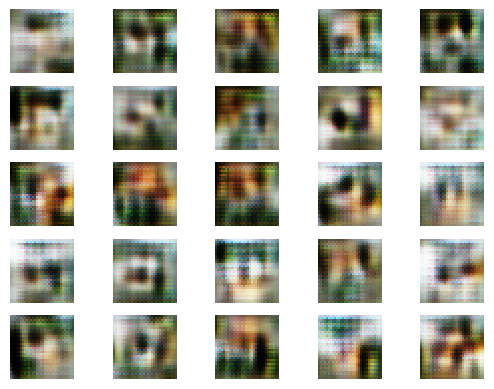

In [40]:
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images stored in the variable examples as a subplot (grid) of size nxn
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# Load the trained generator network
model = load_model('cifar_generator_2epochs.h5') #Model trained for 100 epochs
# Generate the random latent vectors
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# Generate images using the trained generator network and the randomly generated latent vectors as input
X = model.predict(latent_points)

# The 2 commands below convert each pixel value of each generated image back to [0,255] (in case you want to save each generated image as JPEG or other format). Hence, these 2 commands below are optional.
X = (X + 1) / 2.0 # Convert each pixel value of each generated image from [-1,1] to [0,1] 

import numpy as np
X = (X*255).astype(np.uint8) # Convert each pixel value of each generated image from [0,1] to [0,255], then set each pixel value as an unsigned integer 8-bit type.

# Plot the result
show_plot(X, 5) # Show all the generated images as a subplot (grid) of 5x5

# Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck